In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
WIDTH = 8
HEIGHT = 5
GRID = np.zeros([HEIGHT + 1, WIDTH + 1])
START = np.array([2,0])
GOAL = np.array([0, 8])
WALL = [
    [1,2], [2,2], [3,2], [4, 5], [0,7], [1,7], [2,7],
]
GRID[START[0], START[1]] = 1
GRID[GOAL[0], GOAL[1]] = 3
for w in WALL:
    GRID[w[0], w[1]] = 2

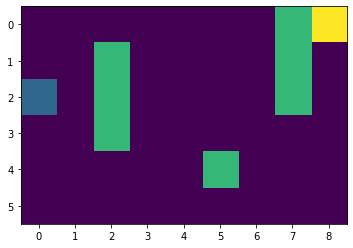

In [3]:
plt.figure()
plt.imshow(GRID)

In [4]:
class Player:
    def __init__(self,start=START, width=WIDTH, height=HEIGHT):
        self.position = START
        self.actions = [
            np.array([0,1]), #RIGHT
            np.array([0,-1]), #LEFT
            np.array([-1,0]), #UP
            np.array([1,0]) #DOWN
        ]
    
    def move(self, action):
        new_position = self.position + action
        list_pos = list(new_position)
        if np.any(list_pos in WALL) or (list_pos[0] < 0) or (list_pos[1] < 0) or (list_pos[0] > HEIGHT) or (list_pos[1] > WIDTH):
            return
        else:
            self.position = new_position
    
    def check_finish_line(self):
        return all(self.position == GOAL)
    
    def reset(self):
        self.position = START

In [5]:
player = Player()

In [6]:
class DynaQ:
    def __init__(self, player, grid, epsilon=0.1, alpha=0.1, n=50):
        self.player = player
        self.grid = grid
        self.Q = np.zeros([grid.shape[0], grid.shape[1], len(self.player.actions)])
        self.model_state = np.zeros([grid.shape[0], grid.shape[1], len(self.player.actions)], dtype=object)
        self.model_reward = np.zeros([grid.shape[0], grid.shape[1], len(self.player.actions)])
        self.epsilon = epsilon
        self.alpha = alpha
        self.n = n
        self.visited_state = np.zeros([grid.shape[0], grid.shape[1]])
        self.action_taken = np.zeros([grid.shape[0], grid.shape[1], len(self.player.actions)])
        
    def e_greedy(self, state):
        if np.random.random() >= self.epsilon:
            action = np.argmax(self.Q[state[0], state[1]])
        else:
            action = np.random.choice(len(self.player.actions))
        return action        
        
    def generate_episode(self, verbose=False):
        self.player.reset()
        pos = []
        not_done = True
        while not_done:
            # Load S
            s1 = self.player.position
            pos.append(s1)
            if verbose:
                print("Current position, ", (pos[-1]))
            action1 = self.e_greedy(s1)
            if verbose:
                print("Action taken ", self.player.actions[action1])
            # Take action A; observe resultant reward, R, and state S'
            self.player.move(self.player.actions[action1])
            s2 = self.player.position
            if self.player.check_finish_line():
                pos.append(self.player.position)
                reward = 1
                not_done = False
                if verbose:
                    print(f"You reached the goal in {len(pos)} steps")
            else:
                reward = 0
            # Direct RL
            self.Q[s1[0],s1[1], action1] += self.alpha * (reward + 0.95*np.max(self.Q[s2[0],s2[1]]) - self.Q[s1[0],s1[1], action1])
            # Updating model
            self.model_state[s1[0],s1[1],action1] = s2
            self.model_reward[s1[0],s1[1], action1] = reward
            self.action_taken[s1[0],s1[1],action1] = True
            self.visited_state[s1[0],s1[1]] = True
            for i in range(self.n):
                s = random.sample(list(np.argwhere(self.visited_state == True)), 1)[0]
                try:
                    a = np.random.choice(np.argwhere(self.action_taken[s[0],s[1]]==1)[:,0])
                    r = self.model_reward[s[0],s[1],a]
                    next_s = self.model_state[s[0],s[1],a]
                    self.Q[s[0],s[1],a] += self.alpha * (r + 0.95 * np.max(self.Q[next_s[0],next_s[1]]) - self.Q[s[0],s[1], a])
                except ValueError:
                    continue
        return pos

In [7]:
dyna_10 = DynaQ(player, GRID, n=10)
dyna_50 = DynaQ(player, GRID, n=50)
dyna_0 = DynaQ(player, GRID, n=0)

In [8]:
for i in range(50):
    dyna_10.generate_episode()
    dyna_50.generate_episode()
    dyna_0.generate_episode()

In [9]:
p10 = dyna_10.generate_episode(verbose=True)

Current position,  [2 0]
Action taken  [-1  0]
Current position,  [1 0]
Action taken  [-1  0]
Current position,  [0 0]
Action taken  [-1  0]
Current position,  [0 0]
Action taken  [0 1]
Current position,  [0 1]
Action taken  [1 0]
Current position,  [1 1]
Action taken  [-1  0]
Current position,  [0 1]
Action taken  [0 1]
Current position,  [0 2]
Action taken  [0 1]
Current position,  [0 3]
Action taken  [0 1]
Current position,  [0 4]
Action taken  [0 1]
Current position,  [0 5]
Action taken  [0 1]
Current position,  [0 6]
Action taken  [1 0]
Current position,  [1 6]
Action taken  [1 0]
Current position,  [2 6]
Action taken  [0 1]
Current position,  [2 6]
Action taken  [1 0]
Current position,  [3 6]
Action taken  [0 1]
Current position,  [3 7]
Action taken  [0 1]
Current position,  [3 8]
Action taken  [-1  0]
Current position,  [2 8]
Action taken  [-1  0]
Current position,  [1 8]
Action taken  [-1  0]
You reached the goal in 21 steps


In [10]:
p50 = dyna_50.generate_episode(verbose=True)

Current position,  [2 0]
Action taken  [0 1]
Current position,  [2 1]
Action taken  [1 0]
Current position,  [3 1]
Action taken  [1 0]
Current position,  [4 1]
Action taken  [0 1]
Current position,  [4 2]
Action taken  [0 1]
Current position,  [4 3]
Action taken  [-1  0]
Current position,  [3 3]
Action taken  [0 1]
Current position,  [3 4]
Action taken  [0 1]
Current position,  [3 5]
Action taken  [1 0]
Current position,  [3 5]
Action taken  [-1  0]
Current position,  [2 5]
Action taken  [0 1]
Current position,  [2 6]
Action taken  [1 0]
Current position,  [3 6]
Action taken  [0 1]
Current position,  [3 7]
Action taken  [0 1]
Current position,  [3 8]
Action taken  [-1  0]
Current position,  [2 8]
Action taken  [-1  0]
Current position,  [1 8]
Action taken  [-1  0]
You reached the goal in 18 steps


In [11]:
p0 = dyna_0.generate_episode(verbose=True)

Current position,  [2 0]
Action taken  [0 1]
Current position,  [2 1]
Action taken  [-1  0]
Current position,  [1 1]
Action taken  [-1  0]
Current position,  [0 1]
Action taken  [0 1]
Current position,  [0 2]
Action taken  [0 1]
Current position,  [0 3]
Action taken  [0 1]
Current position,  [0 4]
Action taken  [0 1]
Current position,  [0 5]
Action taken  [0 1]
Current position,  [0 6]
Action taken  [1 0]
Current position,  [1 6]
Action taken  [1 0]
Current position,  [2 6]
Action taken  [1 0]
Current position,  [3 6]
Action taken  [0 1]
Current position,  [3 7]
Action taken  [0 1]
Current position,  [3 8]
Action taken  [-1  0]
Current position,  [2 8]
Action taken  [-1  0]
Current position,  [1 8]
Action taken  [-1  0]
You reached the goal in 17 steps


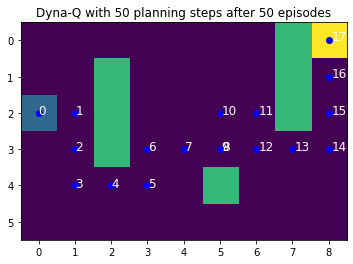

In [12]:
plt.figure()
plt.imshow(GRID)
plt.title("Dyna-Q with 50 planning steps after 50 episodes")
for i, s in enumerate(p50):
    x = s[1]
    y = s[0]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12, color='white')